In [2]:
# Install PyCaret if not already installed
# (Run only once)
!pip install pycaret --quiet


In [3]:
import pandas as pd
from pycaret.classification import *

# Load the training and test datasets
train = pd.read_csv("/Users/spartan/Documents/GitHub/Pycaret_Assignment/Binary Classification/dataset/train.csv")
test = pd.read_csv("/Users/spartan/Documents/GitHub/Pycaret_Assignment/Binary Classification/dataset/test.csv")

# Optionally, view shape and columns
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (750000, 18)
Test shape: (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
# Sample 30% of data for quick experiments
# You can change 0.3 to a smaller/larger fraction
train_sampled = train.sample(frac=0.3, random_state=42)
print("Sampled data shape:", train_sampled.shape)


Sampled data shape: (225000, 18)


In [5]:
# Check column names and target variable
train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
# Setup PyCaret classification environment (compatible with PyCaret >=3.0)
clf = setup(
    data=train_sampled,
    target='y',
    session_id=123,
    fix_imbalance=True,   # handle imbalance if present
    normalize=True,       # normalize numeric features
    verbose=False         # keep logs quiet
)


In [7]:
# Compare a suite of classifiers and pick the best performer
best_model = compare_models()

# Optional: capture and inspect the leaderboard table
leaderboard = pull()
leaderboard.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9314,0.9627,0.6598,0.7458,0.7001,0.6616,0.6632,16.5570
xgboost,Extreme Gradient Boosting,0.9307,0.9620,0.6605,0.7407,0.6983,0.6593,0.6607,1.5670
lightgbm,Light Gradient Boosting Machine,0.9301,0.9615,0.6484,0.7432,0.6925,0.6533,0.6553,1.5110
rf,Random Forest Classifier,0.9263,0.9564,0.6202,0.7319,0.6714,0.6302,0.6330,6.0330
gbc,Gradient Boosting Classifier,0.9206,0.9518,0.6910,0.6671,0.6788,0.6335,0.6337,12.7470
et,Extra Trees Classifier,0.9205,0.9496,0.5759,0.7143,0.6376,0.5936,0.5980,7.5060
ada,Ada Boost Classifier,0.9145,0.9427,0.6286,0.6543,0.6411,0.5926,0.5928,3.1160
dt,Decision Tree Classifier,0.9001,0.7745,0.6087,0.5852,0.5966,0.5396,0.5398,1.1340
knn,K Neighbors Classifier,0.8849,0.8606,0.6363,0.5213,0.5730,0.5073,0.5106,4.9770
dummy,Dummy Classifier,0.8786,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7170


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9314,0.9627,0.6598,0.7458,0.7001,0.6616,0.6632,16.557
xgboost,Extreme Gradient Boosting,0.9307,0.9620,0.6605,0.7407,0.6983,0.6593,0.6607,1.567
lightgbm,Light Gradient Boosting Machine,0.9301,0.9615,0.6484,0.7432,0.6925,0.6533,0.6553,1.511
rf,Random Forest Classifier,0.9263,0.9564,0.6202,0.7319,0.6714,0.6302,0.6330,6.033
gbc,Gradient Boosting Classifier,0.9206,0.9518,0.6910,0.6671,0.6788,0.6335,0.6337,12.747


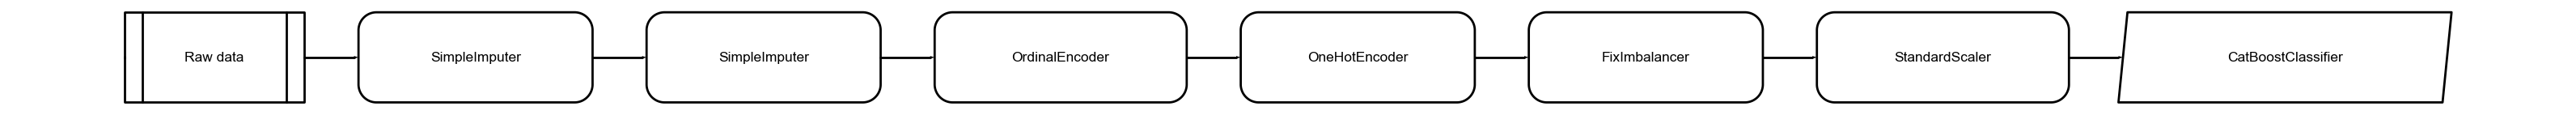

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [8]:
# Evaluate the best-performing model using interactive dashboard
evaluate_model(best_model)

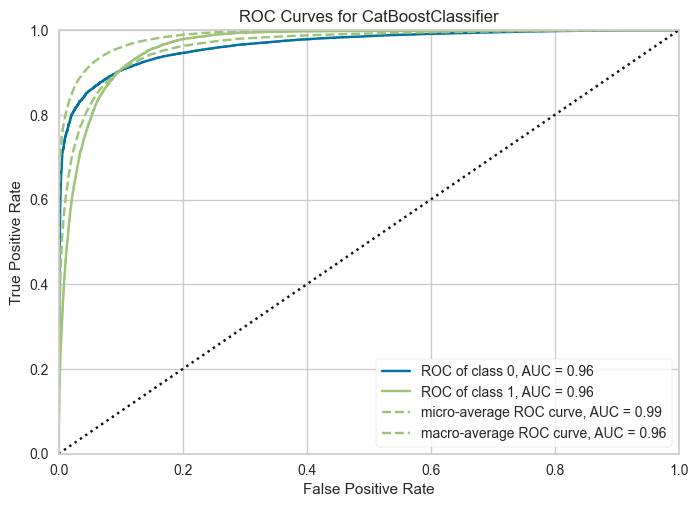

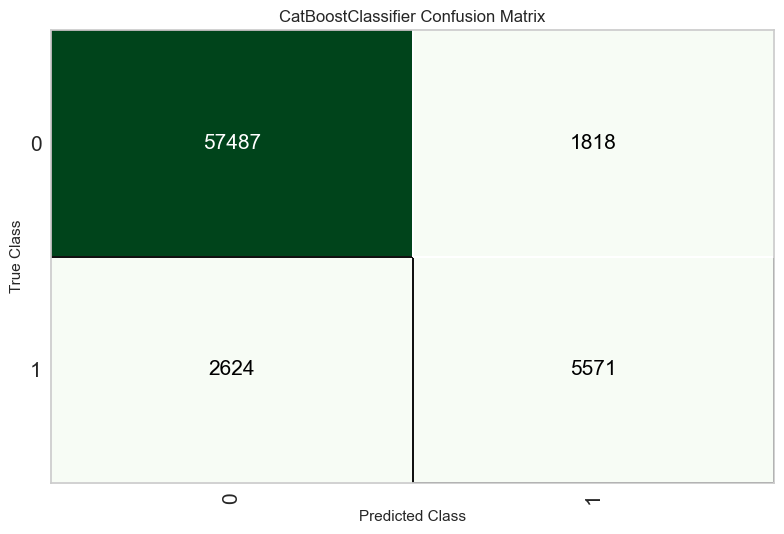

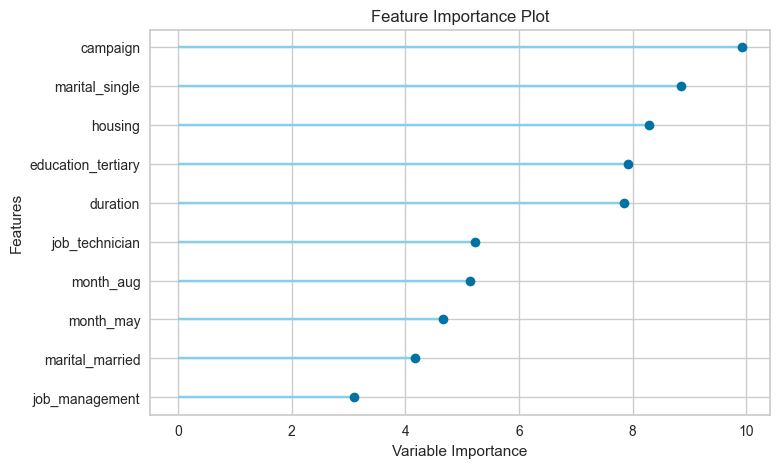

In [9]:
# ROC curve
plot_model(best_model, plot='auc')

# Confusion Matrix
plot_model(best_model, plot='confusion_matrix')

# Feature Importance
plot_model(best_model, plot='feature')


In [10]:
# Predict on the internal hold-out set (from setup's train/validation split)
holdout_predictions = predict_model(best_model)

# Peek at predictions (original features + Label and Score columns)
holdout_predictions.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9342,0.9649,0.6798,0.7540,0.7150,0.6779,0.6790


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,prediction_label,prediction_score
362197,362197,60,retired,divorced,primary,no,8,no,no,unknown,5,jun,159,1,-1,0,unknown,0,0,0.9983
413861,413861,31,technician,single,secondary,no,3382,no,no,cellular,12,aug,523,2,-1,0,unknown,0,0,0.6044
358049,358049,33,self-employed,married,primary,no,3185,yes,no,cellular,14,may,178,1,-1,0,unknown,0,0,0.9883
301531,301531,32,blue-collar,married,primary,no,0,yes,no,unknown,20,may,311,1,-1,0,unknown,0,0,0.9978
636848,636848,48,blue-collar,married,secondary,no,0,yes,no,unknown,6,may,214,1,-1,0,unknown,0,0,0.9993


In [11]:
# Predict on the external test dataset
test_predictions = predict_model(best_model, data=test)

# Save predictions to CSV for later use or submission
test_predictions.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved as test_predictions.csv")


✅ Predictions saved as test_predictions.csv


In [12]:
# Finalize (retrain on full training split) and persist the pipeline
final_model = finalize_model(best_model)

# Save the finalized model for later reuse/deployment
save_model(final_model, 'bank_classifier_model')

# Optional: quick sanity check (load and predict)
# loaded_model = load_model('bank_classifier_model')
# sanity_preds = predict_model(loaded_model, data=test.head(5))


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['id', 'age', 'balance', 'day',
                                              'duration', 'campaign', 'pdays',
                                              'previous'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrap...
                  TransformerWrapper(exclude=None, include=None,
                  

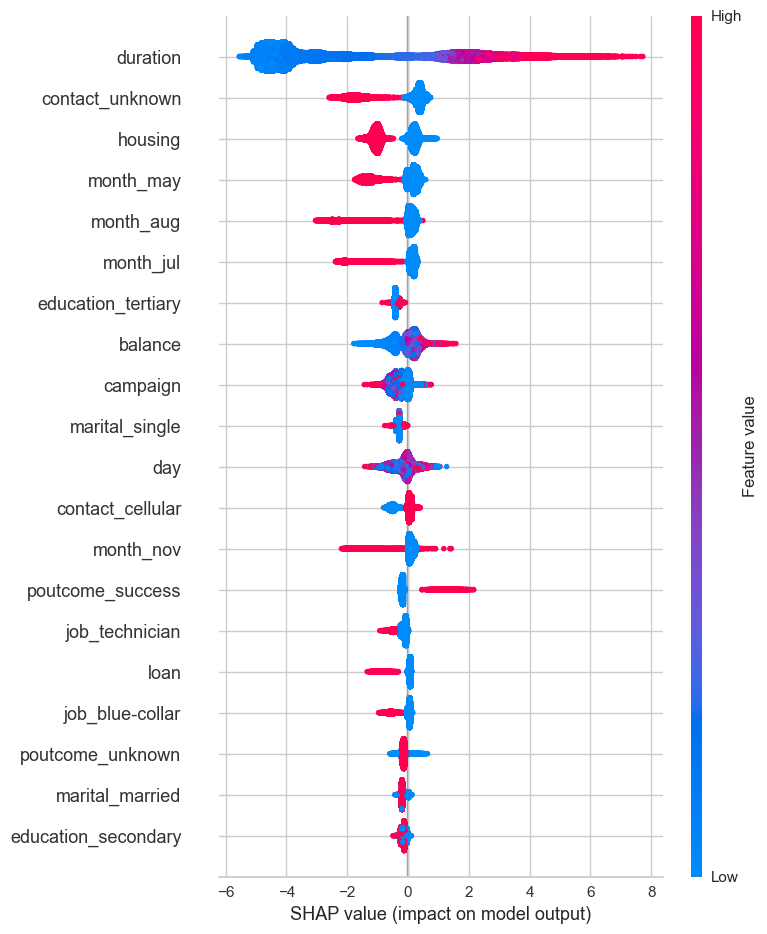

In [17]:
# Optional: SHAP summary via a tree model (works for rf, xgboost, lightgbm, dt, et, catboost)
try:
    interpret_model(best_model)  # will work if best_model is tree-based
except TypeError:
    # Train a quick Random Forest just for SHAP
    rf_model = create_model('rf')
    interpret_model(rf_model)


In [ ]:
# Leaderboard of all models tried so far
lb = get_leaderboard()
display(lb.head(10))

# Optional: have AutoML select the best model for a chosen metric (AUC here)
best_auc_model = automl(optimize='AUC')
print("AutoML-selected   model (by AUC):", best_auc_model)

# Quick peek at its ROC curve and confusion matrix
plot_model(best_auc_model, plot='auc')
plot_model(best_auc_model, plot='confusion_matrix')


,Model Name,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Index,,,,,,,,,
0,Logistic Regression,"(TransformerWrapper(exclude=None,\n ...",0.8744,0.9418,0.8613,0.4904,0.6249,0.5562,0.5881
1,K Neighbors Classifier,"(TransformerWrapper(exclude=None,\n ...",0.8849,0.8606,0.6363,0.5213,0.5730,0.5073,0.5106
2,Naive Bayes,"(TransformerWrapper(exclude=None,\n ...",0.8507,0.8227,0.6179,0.4216,0.5012,0.4171,0.4276
3,Decision Tree Classifier,"(TransformerWrapper(exclude=None,\n ...",0.9001,0.7745,0.6087,0.5852,0.5966,0.5396,0.5398
4,SVM - Linear Kernel,"(TransformerWrapper(exclude=None,\n ...",0.8605,0.9394,0.8859,0.4612,0.6066,0.5318,0.5738
5,Ridge Classifier,"(TransformerWrapper(exclude=None,\n ...",0.8752,0.9412,0.8556,0.4921,0.6248,0.5564,0.5870
6,Random Forest Classifier,"(TransformerWrapper(exclude=None,\n ...",0.9263,0.9564,0.6202,0.7319,0.6714,0.6302,0.6330
7,Quadratic Discriminant Analysis,"(TransformerWrapper(exclude=None,\n ...",0.8669,0.8458,0.6294,0.4672,0.5338,0.4586,0.4670
8,Ada Boost Classifier,"(TransformerWrapper(exclude=None,\n ...",0.9145,0.9427,0.6286,0.6543,0.6411,0.5926,0.5928
